# A Test Case for Refactoring a Basic Portfolio Optimization Workflow

We recreated a basic portfolio optimization workflow from 
functions that will eventually be called from an automated pipeline.
Then compared to a past project using assets from the 
S&P 500 to ensure proper implimentation. 
We then replaced the current statistical estimators,
which assume a normal distribution, 
with robust estimators like those used in past projects through 202410-202411.
Finally we considered a slight variation that uses a bayesian approch 
to incorperate expectations derived from other sources.
Eventaully the functions called here will become a key part of the 
inital Condor Funds web-based minimally viable prototype.

The goal here is to identify:
* create seperate functions to support a basic portfolio optimization workflow
* call them from this project to comapre against a past project to ensure concistancy
* add alternate stratagies from past projects and compare
* add portfolio class and asset specific stat meta props
* add an alternate bayesian optimization approch and compare 

### *Notice*
*We stress that none of our Jupyter Notebook projects are to be considered final and of publication quality unless otherwise stated. We also provide no warranty or guarantee of any kind. These projects are meant for testing code and learning concepts in a transparent, and often evolving manner. If new methodologies, stratagies or fundamental understandings are applied in the future, they will most likely be explored in future projects. For transparency and documentation, old projects will not be removed but instead will be deprecated (and clearly marked as such). Look for updates on GitHub https://github.com/Rtasseff/condor_test/tree/main/project*

## Setup

In [1]:
# data set
datasetName = 'sp500_combined.csv'

# Paths

# Analytics dir path *USER SET*
analyticsDir = '/Users/rtasseff/projects/condor_test/analytics'
# Data dir path *USER SET*
dataDir = '/Users/rtasseff/projects/tmp/data_analytics_v1'
import sys
# adding analytics to the system path
sys.path.insert(0, analyticsDir)

from data_mining import load
from functions import genStats
from functions import genFin
from functions import assetPreassess as apa
from functions import utils
from functions import portOpt as po
from classes import CondorCoreObs as condor


import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd



## Background 

Educational Source:
https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/dd628e151309a7f23962b1a31b9356e5_MIT15_401F08_lec13.pdf

*** need to review all text ***
Modern Portfolio Theory (MPT) is a concept in Finance that describes ways of diversifying and allocating assets in a financial portfolio in order to maximize the portfolio's expected return given the owner's risk tolerance. American economist Harry Markowitz first introduced MPT in a 1952 paper. The theory was intended to eliminate ideosyncratic risk, which is the risk inherent in a particular investment due to its unique characteristics.

*** At some point want to stress that mathmatically we ae using volitility as a statistical measure for 'risk', but the use of risk has some implied meaning that is not covered by this analysis. then further expand on what it might mean in a later example ***

A key component of this framework is diversification. When using MPT, an investor bundles different types of investments together so that when some of the securities fall in value, other securities rise in equal amount. Thus, the overall portfolio stays even but as markets rise overall, the portfolio rises along with the market's inside tide.

MPT argues that any given investment's risk and return characteristics should not be viewed alone but evaluated by how it affects the overall portfolio's risk and return. That is, an investor can construct a portfolio of multiple assets that will result in greater returns without a higher level of risk. As an alternative, starting with a desired level of expected return, the investor can construct a portfolio with the lowest possible risk that is capable of producing that return.

MPT uses precise financial mathematics to carefully construct the portfolio. The steps involved included:
1. portfolio selection - valuing and choosing the securities that might be included in the portfolio;
2. portfolio optimization - calculating the optimal allocation, or percentage, for each of the selected assets (i.e. choosing the right mix of assets to maximize return and/or minimize risk);
3. portfolio rebalancing - after the portfolio is implimented (i.e. assets are purchased) the value of individual assets will change over time and the holdings of various assets will need to be decreased or increased to ensure the original allocation (i.e. to maintain the correct overall percentage of each asset); 
4. portfolio reallocation - periodically it is important to check on the behaviour of individual assets as changes to the asset allocations may needed.

*** Went off on a tangent here, need to focus this ***
In the analysis here, we focused on step (2). Other steps will be convered in future projects and Condor Funds materials. It is worth pointing out that step (4) is of important practicale concern. Since the analysis here is enterly dependant on historical data, future events may change the statistical estiamtes of this data as they ocurr. In addition, there are many other market factors to consider for investment choices. The importance of these factors depends on the preferences of the individual investor. In particular, the time-frame for investment and the size (number of different assets) of the portfolio impact the liklyhood that observed returns and risks mirror historical ones. Longer investment time-frames and bigger portfolios (e.g. a 'buy-and-hold' straetegy over 10+ years on a well diversifed portfolio) allow for noise and abnormal events to smooth out, or correct themselves, over time. In these cases, reallocation could be done by simply repeating step (2). Shorter time frames (e.g. < 5 years) become increasingly reliant on other market insights not considered here. Of course there is no guarentee on any time-frame, as past performance does not always mean future results. For example, a new technology could drive a once strong company into bankruptcy over the course of a decade. In this case there would be no chance of recovery over time. However, there are stratagies accessible to even novice investors for periodically (sometimes without effort) repeating step (1) as well, but these will not be discussed here. 


Valuing the securities that might be included in the portfolio.
Calculating the desired asset allocation, that is, the mix of assets.
Performing calculations to optimize the portfolio to get the maximum amount of return for the minimum amount of risk.
Using financial analysis to monitor the portfolio to see if it meets expectations and then making changes to the individual securities or asset mix when market warrant a change.
An important consideration in MPT is that based on statistical measures such as variance and correlation, a single investment's performance is less important than how it impacts the entire portfolio.

MPT also assumes that investors are risk-averse, meaning that they prefer a less risky portfolio to a riskier one for a given level of return. As a practical matter, risk aversion implies that most people should invest in multiple asset classes (stocks, bonds, commodities, cash equivalents or cryptocurrencies for example).

## Data

In [2]:
# Read saved date base


# get all data
assets = load.multiAssetHist_CSV(dataDir+'/'+datasetName)
print('Full data set of assets')
assets
assets.info


Full data set of assets


<bound method DataFrame.info of Symbol               A        AAL        AAPL        ABBV        ABNB  \
Date                                                                    
2014-04-01   36.972244  35.767616   17.015982   34.212463         NaN   
2014-04-02   37.175602  35.550785   17.044250   35.026749         NaN   
2014-04-03   37.129684  35.201973   16.926130   35.131809         NaN   
2014-04-04   36.454021  34.466633   16.707170   34.278126         NaN   
2014-04-07   35.653683  33.731285   16.444855   33.240589         NaN   
...                ...        ...         ...         ...         ...   
2024-03-22  147.210846  14.820000  172.046646  176.798874  167.860001   
2024-03-25  145.323914  14.920000  170.618591  176.878128  167.990005   
2024-03-26  144.175781  14.920000  169.480133  177.532028  167.389999   
2024-03-27  147.130981  15.300000  173.075241  178.681305  166.410004   
2024-03-28  145.273987  15.350000  171.247726  180.415100  164.960007   

Symbol            

In [3]:
# get subset

# select stocks of interest by symbol list *USER SET*
stocklist = ["MSFT", "NEE", "CVX"]

assetsSub = assets[stocklist]

print('----------------')
print('Subset of assets')
print('----------------')

assetsSub.head()

prices, dates, syms = load.df2np(assetsSub)

print('')
print('- Prices:')
print(prices)

print('')
print('- Dates:')
print(dates)

print('')
print('- Symbols:')
print(syms)

----------------
Subset of assets
----------------

- Prices:
[[ 35.0114975   18.32213402  78.05315399]
 [ 34.95233917  18.16374969  78.28272247]
 [ 34.6649437   18.27191544  78.07941437]
 ...
 [420.89080811  61.43000031 155.27000427]
 [420.67120361  63.79000092 156.3500061 ]
 [419.9624939   63.90999985 157.74000549]]

- Dates:
['2014-04-01T00:00:00.000000000' '2014-04-02T00:00:00.000000000'
 '2014-04-03T00:00:00.000000000' ... '2024-03-26T00:00:00.000000000'
 '2024-03-27T00:00:00.000000000' '2024-03-28T00:00:00.000000000']

- Symbols:
['MSFT' 'NEE' 'CVX']


In [4]:
# optimization

# compare against old results
period=1
returns = genFin.returns(prices,period=period,metric='Log')
# use for spot check
print(np.log(34.95233917/35.0114975))
print(returns)
returnDates = dates[period:]

returnExps, returnDisps = genFin.calc_return_prop(returns,'Normal')

print(returnExps)
print(returnDisps**2)
print(returnDates)
print(len(returns))

"""RTasseff reviewed code and found differences this, and an old code example.
In old example code all rows containing nan values were removed, 
which removes data for all symbols for that date if one symbol has nan.
One example of a major impact this has is that Air BnB was added in 2023.
So there are nans for ABNB for all times before 2023.
A direct comparision to the new workflow could not be made.
We decided against rewriting anything here or there for the sole purpose of 
comparision.
The old code was only used as an example of the method,
no actianable analysis was ever done or planned, it was just a learning example.
We see no reason to spend more time on it.
We did some hand spot checking on the returned values here.
One example is shown.  
More were done in ipython, manually, but not shown here.
We determined this plus previous tests was sufficent to continue.
"""

-0.0016911120634433268
[[-0.00169111 -0.00868201  0.00293686]
 [-0.00825649  0.00593737 -0.00260048]
 [-0.02819188  0.00432457 -0.00201845]
 ...
 [-0.00286558 -0.0190267  -0.00769874]
 [-0.0005219   0.03769813  0.00693156]
 [-0.00168613  0.00187939  0.00885102]]
[0.00098787 0.00049677 0.00027974]
[0.00028903 0.00022456 0.00035058]
['2014-04-02T00:00:00.000000000' '2014-04-03T00:00:00.000000000'
 '2014-04-04T00:00:00.000000000' ... '2024-03-26T00:00:00.000000000'
 '2024-03-27T00:00:00.000000000' '2024-03-28T00:00:00.000000000']
2515


'RTasseff reviewed code and found differences this, and an old code example.\nIn old example code all rows containing nan values were removed, \nwhich removes data for all symbols for that date if one symbol has nan.\nOne example of a major impact this has is that Air BnB was added in 2023.\nSo there are nans for ABNB for all times before 2023.\nA direct comparision to the new workflow could not be made.\nWe decided against rewriting anything here or there for the sole purpose of \ncomparision.\nThe old code was only used as an example of the method,\nno actianable analysis was ever done or planned, it was just a learning example.\nWe see no reason to spend more time on it.\nWe did some hand spot checking on the returned values here.\nOne example is shown.  \nMore were done in ipython, manually, but not shown here.\nWe determined this plus previous tests was sufficent to continue.\n'

In [5]:
import plotly.graph_objects as go

# calc need stat props

# set from 202411_apa_SP500
month=21
sampInt=20


returns = genFin.returns(prices,month,'Relative')
returnDates = dates[month:]

# get sampling subset
inds = np.arange(0,len(returns),sampInt)
returns_samp = returns[inds]
returnDates_samp = returnDates[inds]

returnExps, returnDisps = genFin.calc_return_prop(returns_samp,'Normal')
returnCoDispsSq = genFin.returnCoDispSq(returns_samp,'Normal')
print('Expected Returns')
print(returnExps)
print('Dispersion in Returns')
print(returnDisps) # this should be very near the diagonal of the codispssq
print('Variation in Returns')
print(returnDisps**2) # this should be very near the diagonal of the codispssq
print('Co-Variation in Returns')
print(returnCoDispsSq)


Expected Returns
[0.02116498 0.01326033 0.00917267]
Dispersion in Returns
[0.06209538 0.05969037 0.08650711]
Variation in Returns
[0.00385584 0.00356294 0.00748348]
Co-Variation in Returns
[[0.00388693 0.00169858 0.00162529]
 [0.00169858 0.00359167 0.00116302]
 [0.00162529 0.00116302 0.00754383]]


In [6]:
# -- testing new functions for opt --

# get portfolio properties
m = len(returnExps)
w = np.ones(m) * (1/m)
returnExp_port, returnDisp_port = genFin.asset_set_perform(w, returnExps, returnCoDispsSq)

# mannual spot check with above
print('-- Portfolio Props, Monthly --')
print(returnExp_port)
print(returnDisp_port)

# returns are calculated on monthly basis so use this 
returnExp_port, returnDisp_port = genFin.asset_set_perform(w, returnExps, returnCoDispsSq, annualizeBy='M')

# mannual spot check with above
print('-- Portfolio Props, Annualized --')
print(returnExp_port)
print(returnDisp_port)

# test to capture errors
print('-- Portfolio Props, Errors --')

# catch weight error
w = np.array([.9,.1,.00001])
try:
    returnExp_port, returnDisp_port = genFin.asset_set_perform(w, returnExps, returnCoDispsSq)
except Exception as exc:
    print(exc)

# size mis match
w = np.ones(m+1) * (1/(m+1))
try:
    returnExp_port, returnDisp_port = genFin.asset_set_perform(w, returnExps, returnCoDispsSq)
except Exception as exc:
    print(exc)




# Function to calculate negative Sharpe ratio
w = np.ones(m) * (1/m)
sr = genFin.asset_set_neg_sharpe_ratio(w, returnExps, returnCoDispsSq)
print('-- Sharpe Ratio --')
print(sr)
sr = genFin.asset_set_neg_sharpe_ratio(w, returnExps, returnCoDispsSq, annualizeBy='M')
print(sr)
sr = genFin.asset_set_neg_sharpe_ratio(w, returnExps, returnCoDispsSq, riskFreeRate=.04, annualizeBy='M')
print(sr)


# Function to maximize Sharpe ratio
print('-- Optimize Sharpe Ratio --')
optResults = po.max_sharpe_ratio(returnExps, returnCoDispsSq, riskFreeRate=0)
print(optResults)
optResults = po.max_sharpe_ratio(returnExps, returnCoDispsSq, riskFreeRate=.04,annualizeBy='M')
print(optResults)

# store solutions for later
wSRMax = optResults['x']
print('weights max SR')
print(wSRMax)
allocationSRMax = pd.DataFrame(100*np.round(wSRMax,2),index=syms,columns=["allocation"])
returnSRMax, dispSRMax = genFin.asset_set_perform(wSRMax, returnExps, returnCoDispsSq, annualizeBy='M')

"""did manual sanity check on output.
mostly MSFT as it had the best returns
NEE had slightly lower retunrs but the variance was slightly lower
and the correlation was only moderate, thus some NEE was included
CVX was basically not included as it had low returns and high variation
and the variation was not negative.

We should note that we have made a trade off 
technically the comparision of assets should fully include the exact same 
time frame.
That is the returns and the variance for all asset use the exact same set of 
time points.
However, this may not always be the case since we deal with missing 
variables pairwise and not in totality.
That is if one asset has a missing variable 
we remove that observation from calculating its return and covariances
but we do not remove that observation from calulating another assets
expected return.
We did this to minimize loss of data.  
In an extream example of data loss above, we say that the limited 
data set avalible for one asset, e.g. only a few years of ABNB, 
could mean that we exclude the vast majority of data for all assets 
even though most had data. 
In that example, this mass exclusion meant that we could 
not have enough data fro a proper sample interval simply 
because one asset did not have enough.
On the outset this seems clear that we want to avoide the case above.
And in our code we have.
However, there is a notable draw back in an extream case of negative correlation.
If asset A and B were perfectly uncorrelated (corr coef = -1)
and they both returned positve returns, it would likly be in our interest 
to have both assets.
In fact this is a perfect diversification senario 
such that holding portfolio A and B can completly remove fluctations 
that are specific to A or B, which is what MFT is trying to do overall.
Since they both have positive returns it means that there is something 
increasing in value that is not specfici to A or B and that non-systemic thing is 
what we want to invest in.
It could be overal economic health and/or industry specific health,
but the fact that it is large than one company, is why it is less risky 
numerically less risky because we, by purpose, reduce the variation 
and more generally as one 2 independent companies are less likly to 
experiance sudden and extream loss compared to one company alone.
However, this only works if the negative corealation and 
the positive expected return are calculated on the exact same time frame.
That is we get positive returns in both over the same observations that
they are varing oppositly.
If there was an odd situation in which A had been around for a long time
and until recently did well,
but recently it did very poorly with -x returns.
Where as B only started recently and did well with +x returns.
Maybe B is making only money from otherwise A oppertunities.
Then a situation would arrise where A has an expected positive return y
despite its recent losses because of it long positve history.
But there are not the returns that yeldied the negative corelation 
as it can only be calculated for the recent history in which B existed.
If the overall trend of A holds, as well as the recent neg correlation 
then that is fine, but if the recent trend holds completly 
then the returns will be closer to -x. 
In this case the perfect neg cross corelation just means one 
companies losses and gains earase the others and you are left with 
0 return (no loss but no gain).
This is the case Where A is just being replaced by B.
We are allowing this as it is an extreme outlier case.
And, if one specific asset was so severly comprimised (lots of missing data)
the pipeline would have already thrown a flag alerting the user that 
this asset will comprimise the statistical asset.
We either hurt the analysis by minimizing the data avalible 
with loss of statistical power or by hurting the analysis fundementals.
We need to add an option to min data for more conservitive estimates.
"""


# Function to minimize portfolio Dispersion
print('-- Optimize Dispersion --')

optResults = po.min_dispersion(returnExps, returnCoDispsSq)
print(optResults)
optResults = po.min_dispersion(returnExps, returnCoDispsSq, annualizeBy='M')
print(optResults)

# store solutions for later
wDispMin = optResults['x']
returnDispMin, dispDispMin = genFin.asset_set_perform(wDispMin, returnExps, returnCoDispsSq, annualizeBy='M')
print('weights min disp')
print(wDispMin)
allocationDispMin = pd.DataFrame(100*np.round(wDispMin,2),index=syms,columns=["allocation"])

print(po._asset_set_disp(w, returnExps, returnCoDispsSq, annualizeBy='None'))
print(po._asset_set_disp(w, returnExps, returnCoDispsSq, annualizeBy='M'))
""" Spot checked for sanity,
Dispersion is lower than the individuals (see above) 
some benifit is gained by a combined portfolio beccause they are not perfectly 
correlated.
But you cannot do much better because they are not anit correlated.
We also hold the least amount of CVX because it has the highest dispersion.
Finally we not that it does not mater if you annualize or not 
because it is just multipling by the same constant value.
The function value changes but the position in weight space does not.
The slight difference is just a numerial one.
"""
# Function to optimize the portfolio for a target return
print('-- Optimize for a return--')
# one solution could exist near even weights
optResults = po.min_dispersion(returnExps, returnCoDispsSq, returnTarget=0.17439, annualizeBy='M')
print(optResults)
# one solution could exist near all wieght on worst (third) asset
optResults = po.min_dispersion(returnExps, returnCoDispsSq, returnTarget=0.1101, annualizeBy='M')
print(optResults)
# manual sanity checks confirmed 



-- Portfolio Props, Monthly --
0.014532659735113574
0.05163569059196007
-- Portfolio Props, Annualized --
0.1743919168213629
0.17887127917836224
-- Portfolio Props, Errors --
Weights in w do not add to one: 1.00001
operands could not be broadcast together with shapes (3,) (4,) 
-- Sharpe Ratio --
-0.2814460224799701
-0.9749576210469613
-0.7513331231189633
-- Optimize Sharpe Ratio --
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.3476977020135474
       x: [ 7.737e-01  2.263e-01  0.000e+00]
     nit: 6
     jac: [-5.855e-05  2.001e-04  5.658e-03]
    nfev: 24
    njev: 6
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0004203601042256
       x: [ 8.503e-01  1.497e-01  9.541e-18]
     nit: 5
     jac: [-2.003e-01 -2.002e-01 -8.275e-02]
    nfev: 20
    njev: 5
weights max SR
[8.50300680e-01 1.49699320e-01 9.54097912e-18]
-- Optimize Dispersion --
 message: Optimization terminated successfully
 success: True
  

[0.02116498 0.01326033 0.00917267]
0.021164978903819156
-- Efficient Frontier --
targets
[0.18442082 0.19137671 0.19833261 0.2052885  0.21224439 0.21920028
 0.22615618 0.23311207 0.24006796 0.24702385 0.25397975]
weights
[[3.59112966e-01 4.62156243e-01 1.78730790e-01]
 [4.18969966e-01 4.28355511e-01 1.52674523e-01]
 [4.78726093e-01 3.94850720e-01 1.26423187e-01]
 [5.38395584e-01 3.61600099e-01 1.00004317e-01]
 [5.98014482e-01 3.28497905e-01 7.34876125e-02]
 [6.57619982e-01 2.95435021e-01 4.69449967e-02]
 [7.17235339e-01 2.62343218e-01 2.04214434e-02]
 [7.80006234e-01 2.19993766e-01 0.00000000e+00]
 [8.53337491e-01 1.46662509e-01 5.55111512e-17]
 [9.26668748e-01 7.33312523e-02 0.00000000e+00]
 [1.00000000e+00 6.84620519e-13 6.63234024e-18]]
r
[0.18442082 0.19137671 0.19833261 0.2052885  0.21224439 0.21920028
 0.22615618 0.23311207 0.24006796 0.24702385 0.25397975]
d
[0.17230124 0.17275059 0.17411488 0.17637274 0.17949039 0.18342398
 0.18812234 0.19354424 0.19998473 0.20749737 0.21597032

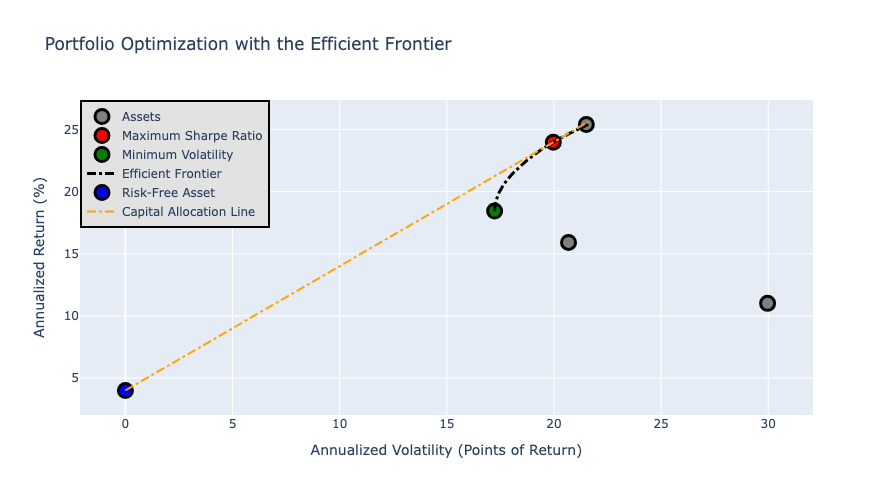

In [25]:
import plotly.graph_objects as go

# Function to efficent frontier 
# get return seris to calculate over 



print(returnExps)
print(np.max(returnExps))

# we will be looking at annualized data for most of going forward
# recall that returns were originally done in months
returnExpsAnn, returnDispsAnn = genFin.annualize(returnExps, returnDisps, 'M')

# the lowest return that has a guaranteed solution is likly at the min variance 
# the highest possible (without leveraging) is 100% w on the max single return
returnTargets = np.linspace(returnDispMin, np.max(returnExpsAnn), 101) #returnSRMax

# the opt method does annualize internally, so send pre annualized
# in future work we need to clean this up
wEF= po.calc_efficient_frontier(returnExps, returnCoDispsSq, returnTargets, riskFreeRate=0.04, annualizeBy='M')

# calculate the properties for each wighting 
# optimization is not exact so while the target return was set as a goal
# it may not have been achived, need to recalculate 
n = len(wEF)
returnExps_EF = np.zeros(n) * np.nan
returnDisps_EF = np.zeros(n) * np.nan

for i in range(n):
    returnExps_EF[i], returnDisps_EF[i] = genFin.asset_set_perform(wEF[i], returnExps, returnCoDispsSq, annualizeBy='M')
    
print('-- Efficient Frontier --')
print('targets')
print(returnTargets[::10])
print('weights')
print(wEF[::10])


# we expectd a smooth transition from the 
# precalculated min disp weights to the 
# precalculated max SR weights and we got it
# cehck



print('r')
print(returnExps_EF[::10])
print('d')
print(returnDisps_EF[::10])

# Asset points

asset_text = [
    f"{sym}: Return: {round(ret * 100, 2)}% +/- points {round(vol * 100, 2)} ({round(vol/ret * 100 * np.sqrt(12)/12, 2)}%)"
    for sym, ret, vol in zip(syms, returnExpsAnn, returnDispsAnn)
]


Asset_points = go.Scatter(
    name="Assets",
    mode="markers",
    x=np.round(returnDispsAnn * 100, 2),
    y=[round(ret * 100, 2) for ret in returnExpsAnn],
    marker=dict(
        color="gray",
        size=14,
        line=dict(
            width=3,
            color="black")),
    text=asset_text,
    hoverinfo='text'
)
#plot the efficient frontier

# Max Sharpe Ratio trace
MaxSharpeRatio = go.Scatter(
    name="Maximum Sharpe Ratio",
    mode="markers",
    x=[dispSRMax * 100],
    y=[round(returnSRMax * 100, 2)],
    marker=dict(
        color="red",
        size=14,
        line=dict(
            width=3,
            color="black")),
    text=[f"Return: {round(returnSRMax * 100, 2)}% +/- {round(dispSRMax * 100, 2)} points ({round((dispSRMax/returnSRMax) * 100, 2)}%)<br>{allocationSRMax.to_string()}"],
    hoverinfo='text'
)

# Min Volatility trace
MinVol = go.Scatter(
    name="Minimum Volatility",
    mode="markers",
    x=[dispDispMin * 100],
    y=[round(returnDispMin * 100, 2)],
    marker=dict(
        color="green",
        size=14,
        line=dict(
            width=3,
            color="black")),
    text=[f"Return: {round(returnDispMin * 100, 2)}% +/- {round(dispDispMin * 100,2)} points ({round((dispDispMin/returnDispMin) * 100, 2)}%)<br>{allocationDispMin.to_string()}"],
    hoverinfo='text'
)

# Efficient Frontier trace
efficient_text = [
    f"Return: {round(ret * 100, 2)}% +/- {round(vol * 100,2)} points ({round((vol/ret) * 100, 2)}%)<br>" +
    "<br>".join([f"{symbol}: {round(weight * 100, 2)}%" for symbol, weight in zip(syms, alloc)])
    for ret, vol, alloc in zip(returnExps_EF, returnDisps_EF, wEF)
]


EF_curve = go.Scatter(
    name="Efficient Frontier",
    mode="lines",
    x= np.round(returnDisps_EF * 100, 2),
    y=[round(ret * 100, 2) for ret in returnExps_EF],
    line=dict(color="black", width=3, dash="dashdot"),
    text=efficient_text,
    hoverinfo='text'
)



riskFreeRate = 0.04
# Risk-Free Asset point
rf_point = go.Scatter(
    name="Risk-Free Asset",
    mode="markers",
    x=[0],  # Assuming risk-free rate has zero volatility
    y=[riskFreeRate * 100],
    marker=dict(
        color="blue",
        size=14,
        line=dict(
            width=3,
            color="black")),
    text=f"Risk-Free Rate: {round(riskFreeRate * 100, 2)}%",
    hoverinfo='text'
)
    
# Capital Allocation Line (CAL)
# include risk free point and SR max AND the corrisponding last point on EF line
# need to move the CAL line calcualation to a general function
def f_cal(x, riskFreeRate, returnSRMax, dispSRMax):
    slope = (returnSRMax - riskFreeRate) / dispSRMax 
    y = x * slope + riskFreeRate
    return (y)
    
cal_x = [0, dispSRMax * 100, returnDisps_EF[-1] * 100]
cal_y = [riskFreeRate * 100, returnSRMax * 100, f_cal(returnDisps_EF[-1], riskFreeRate, returnSRMax, dispSRMax) * 100]
CAL = go.Scatter(
    name="Capital Allocation Line",
    mode="lines",
    x=cal_x,
    y=cal_y,
    line=dict(color="orange", width=2, dash="dashdot")
)

data = [Asset_points, MaxSharpeRatio, MinVol, EF_curve, rf_point, CAL]



layout = go.Layout(
    title='Portfolio Optimization with the Efficient Frontier',
    yaxis=dict(title='Annualized Return (%)'),
    xaxis=dict(title='Annualized Volatility (Points of Return)'),
    showlegend=True,
    legend=dict(
        x=0,
        y=1,
        traceorder='normal',
        bgcolor="#E2E2E2",
        bordercolor='black',
        borderwidth=2),
    width=660,
    height=495
)

fig = go.Figure(data=data, layout=layout)
fig.show()






In [ ]:
# double check the classes built for the portfolio
priceLoader = condor.PriceLoader(dataDir+'/'+datasetName)
print(priceLoader.path)
